**Step 1: Import Necessary Libraries**

In [10]:
import os
import random
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt


**Step 2: Mount Google Drive and Define Dataset Path**

In [17]:
from google.colab import drive
drive.mount('/content/drive')

img_path = '/content/drive/MyDrive/Colab Notebooks/Animals'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Step 3: Check Dataset Categories**

In [18]:
# List categories available in the dataset
folders = os.listdir(img_path)
print(f"Classes found: {folders}")


Classes found: ['Jaguar', 'Cheetah', 'Lion', 'Tiger', 'Leopard']


**Step 4: Data Preprocessing**

In [19]:
# Prepare data storage
dataset = []

# Iterate through each folder in the dataset
for folder in folders:
    folder_path = os.path.join(img_path, folder)
    folder_label = folders.index(folder)  # Assign a numeric label to each folder

    # Load images
    for file in tqdm(os.listdir(folder_path), desc=f'Processing {folder}'):
        img_file_path = os.path.join(folder_path, file)
        img_gray = cv2.imread(img_file_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale

        if img_gray is not None:
            img_resized = cv2.resize(img_gray, (256, 256))  # Resize to 256x256
            dataset.append([img_resized, folder_label])

print(f"Total images processed: {len(dataset)}")


Processing Leopard: 100%|██████████| 31/31 [00:00<00:00, 80.37it/s]

Total images processed: 170


**Step 5: Shuffle and Visualize the Data**

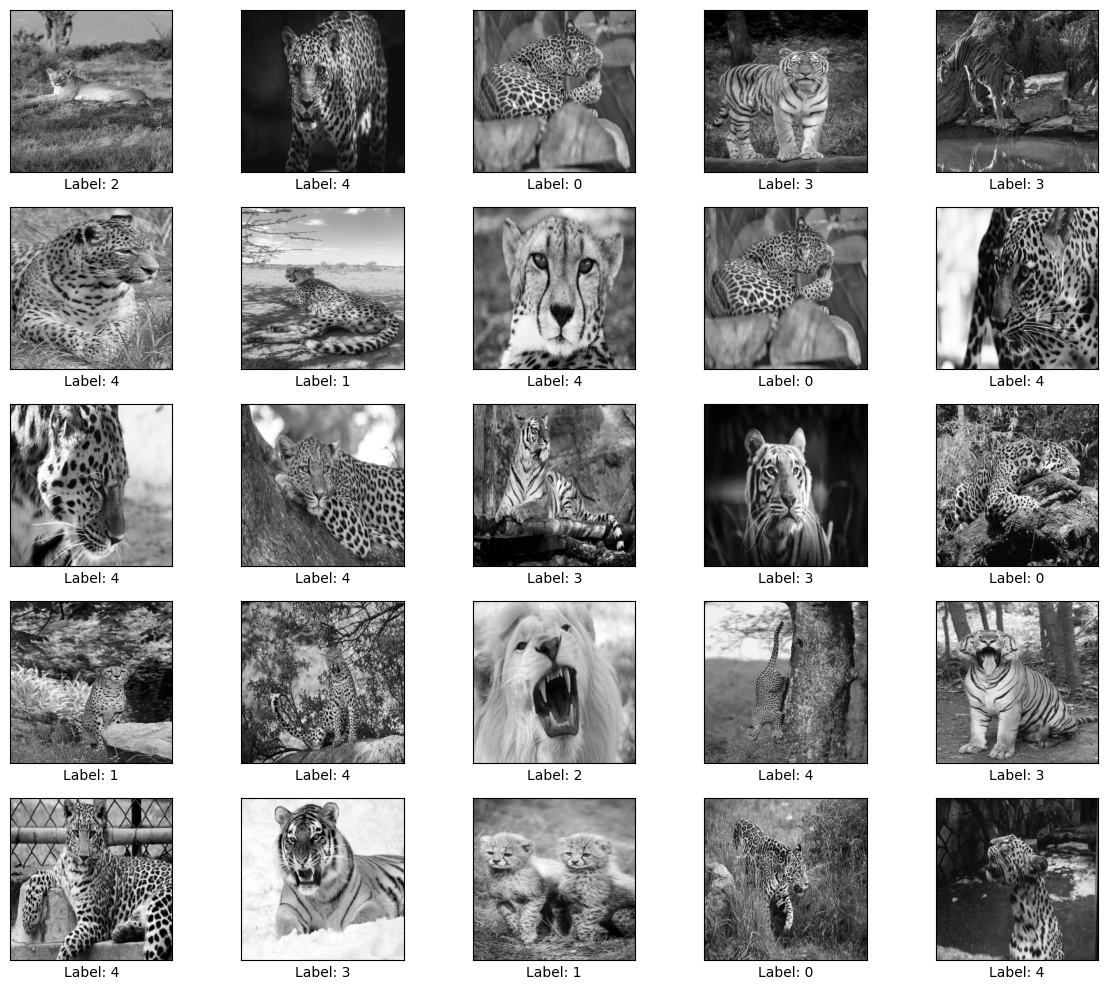

In [26]:
# Shuffle the dataset
random.shuffle(dataset)

# Display random samples from the dataset
plt.figure(figsize=(12, 10))  # Adjust the figure size for better clarity
i = 0
for r in range(5):  # Rows of images
    for c in range(5):  # Columns of images
        plt.subplot(5, 5, i + 1)  # Adjust for a 5x5 grid
        plt.imshow(dataset[i][0], cmap='gray')  # Display the image
        plt.xticks([])  # Remove x-axis ticks
        plt.yticks([])  # Remove y-axis ticks
        plt.xlabel(f"Label: {dataset[i][1]}")  # Show the label
        i += 1  # Increment the counter
plt.tight_layout()  # Ensure there is no overlap
plt.show()


**Step 6: Create Folds for 5-Fold Cross-Validation**

In [22]:
# Split dataset into 5 folds
fold_size = len(dataset) // 5
cross_val_folds = [dataset[i:i + fold_size] for i in range(0, len(dataset), fold_size)]

# Ensure exactly 5 folds are created
if len(cross_val_folds) > 5:
    cross_val_folds[-2].extend(cross_val_folds[-1])
    cross_val_folds.pop()


**Step 7: Define k-NN and Perform Cross-Validation**

In [23]:
# Define the range of K values
k_values = list(range(1, 31))

# Initialize accuracy storage
fold_accuracy_results = [[] for _ in range(5)]
midpoint_accuracies = []

# Perform k-NN with L2 distance for each fold
for fold_idx, validation_set in enumerate(cross_val_folds):
    # Prepare training set by combining all folds except the validation fold
    training_set = sum([fold for idx, fold in enumerate(cross_val_folds) if idx != fold_idx], [])

    print(f"Running Fold {fold_idx + 1}")
    fold_midpoint_acc = []

    for k in k_values:
        correct = 0

        for val_img, val_label in tqdm(validation_set, desc=f"Fold {fold_idx + 1}, k={k}"):
            distances = []

            for train_img, train_label in training_set:
                # Calculate L2 (Euclidean) distance
                l2_dist = np.sqrt(np.sum((train_img - val_img) ** 2))
                distances.append((l2_dist, train_label))

            # Sort distances and retrieve the top-k neighbors
            distances.sort(key=lambda x: x[0])
            nearest_neighbors = [label for _, label in distances[:k]]

            # Predict the label (majority vote)
            prediction = max(set(nearest_neighbors), key=nearest_neighbors.count)

            if prediction == val_label:
                correct += 1

        # Calculate accuracy for the current fold and k value
        fold_accuracy = correct / len(validation_set) * 100
        fold_accuracy_results[fold_idx].append(fold_accuracy)
        fold_midpoint_acc.append(fold_accuracy)

    # Compute midpoint accuracy for the current fold
    midpoint_accuracies.append((min(fold_midpoint_acc) + max(fold_midpoint_acc)) / 2)


Running Fold 1


Fold 1, k=30: 100%|██████████| 34/34 [00:00<00:00, 91.36it/s]


Running Fold 2


Fold 2, k=30: 100%|██████████| 34/34 [00:00<00:00, 59.00it/s]


Running Fold 3


Fold 3, k=30: 100%|██████████| 34/34 [00:00<00:00, 64.96it/s]


Running Fold 4


Fold 4, k=30: 100%|██████████| 34/34 [00:00<00:00, 91.62it/s]


Running Fold 5


Fold 5, k=30: 100%|██████████| 34/34 [00:00<00:00, 102.79it/s]


**Step 8: Average Accuracy and Visualization**

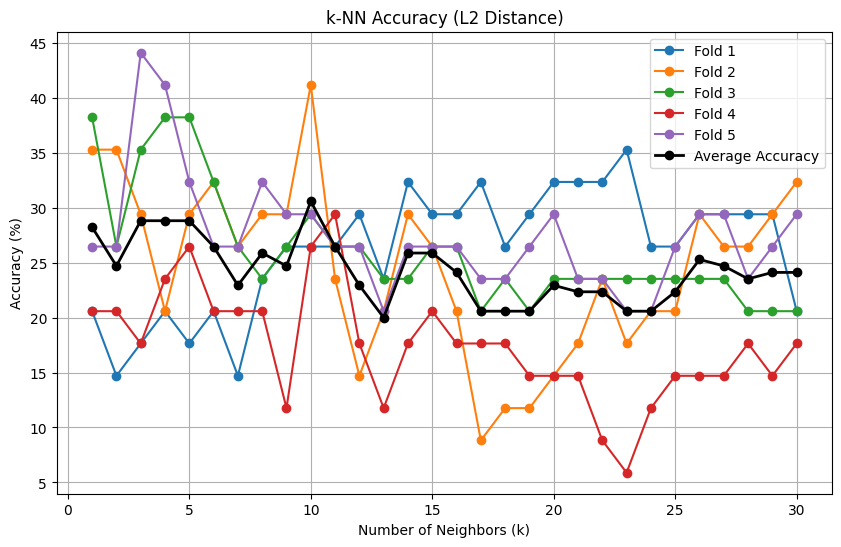

In [24]:
# Compute average accuracy across folds
average_fold_accuracy = np.mean(fold_accuracy_results, axis=0)

# Plot accuracies
plt.figure(figsize=(10, 6))
for fold_num, accuracy_per_fold in enumerate(fold_accuracy_results):
    plt.plot(k_values, accuracy_per_fold, marker='o', label=f'Fold {fold_num + 1}')

# Add the average accuracy plot
plt.plot(k_values, average_fold_accuracy, marker='o', color='black', label='Average Accuracy', linewidth=2)

# Add plot labels and legends
plt.title("k-NN Accuracy (L2 Distance)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()
plt.show()
